# Imports

In [1]:
# Import standard libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Date
import datetime as datetime
import time
from datetime import timedelta

#Math
from math import exp

## Import NYC Parking Violation Data

In [2]:
#Import ticket data, previously cleaned

prec_df = pd.read_csv('Tickets_Data.csv')
prec_df.head()

,Unnamed: 0,Plate,time_issued,Fine_Amount,Amount_Due,Payment_Amount,precinct,State,Bronx,Brooklyn,Manhattan,Queens,Staten_Island,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,9668,KYM0585,2019-12-31 10:26:00,45.0,75.0,75.0,63.0,0,0,1,0,0,0,0,1,0,0,0,0,0
1,9669,3247071,2019-12-31 10:22:00,45.0,55.0,55.0,63.0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,9670,2FWQ91,2019-12-31 10:15:00,45.0,55.0,55.0,63.0,0,0,1,0,0,0,0,1,0,0,0,0,0
3,9671,JDP9488,2019-12-31 10:05:00,45.0,75.0,75.0,63.0,1,0,1,0,0,0,0,1,0,0,0,0,0
4,9672,5TM825,2019-12-31 09:59:00,45.0,75.0,75.0,63.0,0,0,1,0,0,0,0,1,0,0,0,0,0


## Additional Feature Engineering

In [3]:
#Need to convert the datetime column again
prec_df['time_issued']=pd.to_datetime(prec_df['time_issued'], errors='coerce')
prec_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5010716 entries, 0 to 5010715
Data columns (total 20 columns):
 #   Column          Dtype         
---  ------          -----         
 0   Unnamed: 0      int64         
 1   Plate           object        
 2   time_issued     datetime64[ns]
 3   Fine_Amount     float64       
 4   Amount_Due      float64       
 5   Payment_Amount  float64       
 6   precinct        float64       
 7   State           int64         
 8   Bronx           int64         
 9   Brooklyn        int64         
 10  Manhattan       int64         
 11  Queens          int64         
 12  Staten_Island   int64         
 13  weekday_0       int64         
 14  weekday_1       int64         
 15  weekday_2       int64         
 16  weekday_3       int64         
 17  weekday_4       int64         
 18  weekday_5       int64         
 19  weekday_6       int64         
dtypes: datetime64[ns](1), float64(4), int64(14), object(1)
memory usage: 764.6+ MB


In [6]:
#Round to the hour
prec_df['time_issued'] = prec_df['time_issued'].dt.round('H')

# Group by precinct 
chart = prec_df.groupby(["precinct"]).agg({'Fine_Amount':'count'})
chart.isna().sum()

chart['Fine_Amount'].plot.hist(bins=40, edgecolor='k').autoscale(enable=True, axis='both', tight=True)

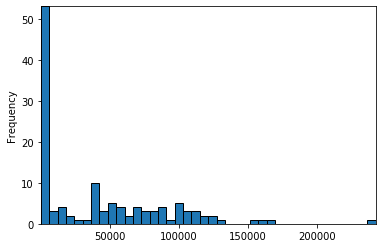

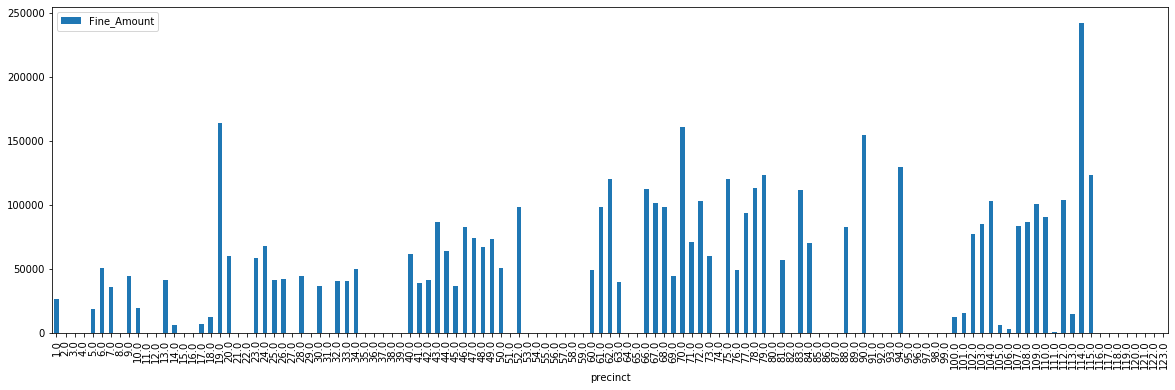

In [8]:
#Look at ticket distrobution across precincts
chart.plot(kind='bar',figsize=(20,6))

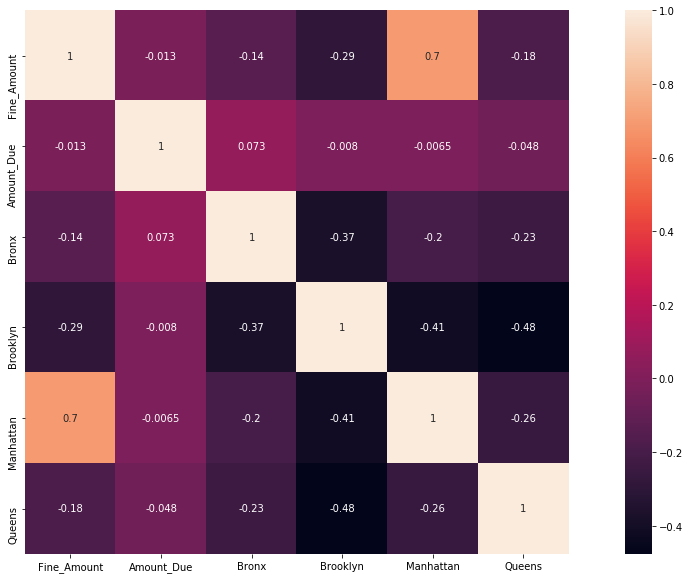

In [7]:
# Create heatmap

corrmat = prec_df[['Fine_Amount','Amount_Due',\
              'Bronx', 'Brooklyn', 'Manhattan', 'Queens'\
             ]].corr()
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrmat,square=True,annot=True)

In [8]:
borough = prec_df.groupby(["Manhattan"]).agg({'Fine_Amount':'sum','Amount_Due':'sum','Payment_Amount':'sum'})
borough.head()

,Fine_Amount,Amount_Due,Payment_Amount
Manhattan,,,
0,184311178.0,4.017089e+07,4.017089e+07
1,51543840.0,8.527051e+06,8.527051e+06


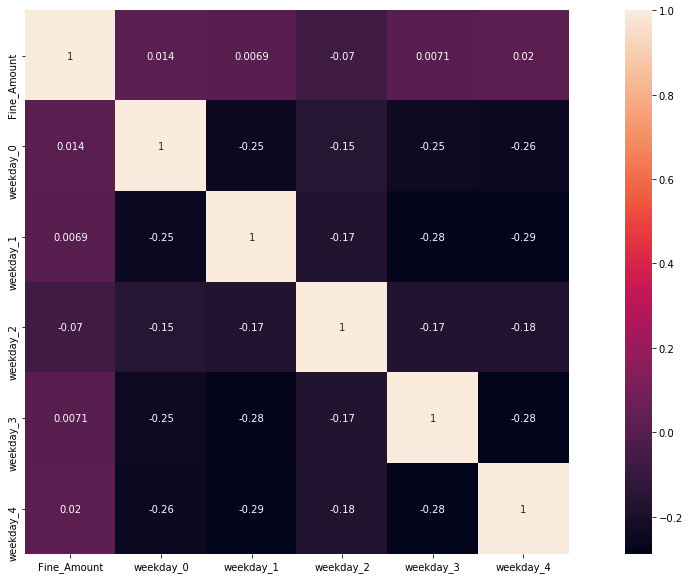

In [9]:
# Create heatmap

corrmat = prec_df[['Fine_Amount',\
              'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4'\
             ]].corr()
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrmat,square=True,annot=True)

findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.


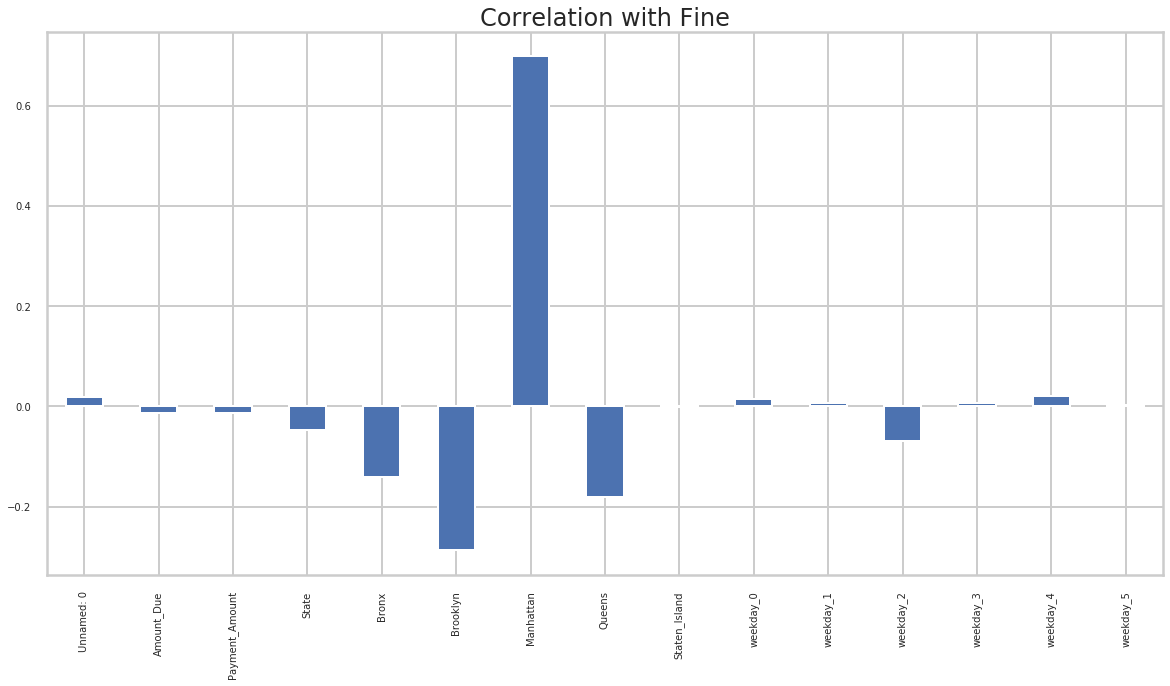

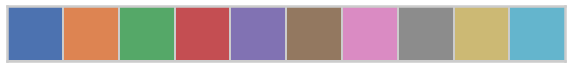

In [10]:
X = prec_df.drop(['Fine_Amount','precinct','weekday_6'],axis=1)
y = prec_df['Fine_Amount']

sns.set(style="whitegrid", palette=("deep"),font='calibri')
sns.set_context("poster")

X.corrwith(prec_df['Fine_Amount']).plot.bar(figsize = (20, 10), title ="Correlation with Fine", fontsize = 10,
rot = 90, grid = True,)

sns.palplot(sns.color_palette())

## Integrate Geopspatial Data (shp)

In [11]:
# Mapping
import geopandas as gpd
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 8, 6
from shapely.geometry import Polygon
import contextily as ctx
from matplotlib import colors
import shapely.geometry as geom
from matplotlib.pylab import rcParams
from pylab import rcParams
# rcParams['figure.figsize'] = 12, 7

In [12]:
districts = gpd.read_file('Shape_Files/geo_export_49baef8e-ad00-4dbc-869a-5cd2bd3bc4d6.shp')
districts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   precinct    77 non-null     float64 
 1   shape_area  77 non-null     float64 
 2   shape_leng  77 non-null     float64 
 3   geometry    77 non-null     geometry
dtypes: float64(3), geometry(1)
memory usage: 2.5 KB


In [13]:
map_df = prec_df.copy()

In [14]:
map_df = map_df.set_index(map_df['time_issued'])

In [15]:
map_df.columns

Index(['Unnamed: 0', 'Plate', 'time_issued', 'Fine_Amount', 'Amount_Due',
       'Payment_Amount', 'precinct', 'State', 'Bronx', 'Brooklyn', 'Manhattan',
       'Queens', 'Staten_Island', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6'],
      dtype='object')

In [16]:
map_df.drop(columns =['Unnamed: 0', 'Plate',
       'Payment_Amount', 'State', 'Bronx', 'Brooklyn', 'Manhattan',
       'Queens', 'Staten_Island'], inplace=True)

In [17]:
map_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5010716 entries, 2019-12-31 10:00:00 to 2017-01-05 12:00:00
Data columns (total 11 columns):
 #   Column       Dtype         
---  ------       -----         
 0   time_issued  datetime64[ns]
 1   Fine_Amount  float64       
 2   Amount_Due   float64       
 3   precinct     float64       
 4   weekday_0    int64         
 5   weekday_1    int64         
 6   weekday_2    int64         
 7   weekday_3    int64         
 8   weekday_4    int64         
 9   weekday_5    int64         
 10  weekday_6    int64         
dtypes: datetime64[ns](1), float64(3), int64(7)
memory usage: 458.7 MB


In [18]:
map_df.shape

(5010716, 11)

In [19]:
# precinct_dummies = pd.get_dummies(prec_df['precinct'], prefix='precinct')
# prec_df = pd.concat([prec_df, precinct_dummies], axis=1)

In [20]:
# map_df.loc[map_df['time_issued']=2017-11-24, 'time_issued']= np.nan 

map_df.loc['2017-11-24']=np.nan
map_df.loc['2018-11-23']=np.nan
map_df.loc['2019-11-29']=np.nan
map_df.dropna(inplace = True)
map_df.shape

(4947379, 11)

In [21]:
map_df = map_df.groupby(["precinct"]).agg({'weekday_0':'sum','weekday_1':'sum','weekday_2':'sum',\
                                           'weekday_3':'sum','weekday_4':'sum','weekday_5':'sum','weekday_6':'sum'})
map_df.head()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
precinct,,,,,,,
1.0,5271.0,6255.0,709.0,6038.0,6519.0,1317.0,16.0
2.0,22.0,21.0,6.0,16.0,21.0,7.0,0.0
3.0,12.0,14.0,1.0,8.0,16.0,3.0,0.0
4.0,16.0,19.0,6.0,11.0,6.0,4.0,0.0
5.0,2763.0,2276.0,2199.0,3887.0,4407.0,3200.0,9.0


In [22]:
map_df2 = map_df.merge(districts, how='left', on='precinct', copy=False)
map_df2.head()
map_df.shape

(123, 7)

In [23]:
map_df2.drop(columns =['shape_area', 'shape_leng'], inplace=True)

In [24]:
# Coordinate reference system based on NYC maps
crs = {'init': 'epsg:2263'}

map_gdf = gpd.GeoDataFrame(map_df2, crs=crs, geometry=map_df2['geometry'])
map_gdf.head()

/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,precinct,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,geometry
0,1.0,5271.0,6255.0,709.0,6038.0,6519.0,1317.0,16.0,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."
1,2.0,22.0,21.0,6.0,16.0,21.0,7.0,0.0,None
2,3.0,12.0,14.0,1.0,8.0,16.0,3.0,0.0,None
3,4.0,16.0,19.0,6.0,11.0,6.0,4.0,0.0,None
4,5.0,2763.0,2276.0,2199.0,3887.0,4407.0,3200.0,9.0,"POLYGON ((-73.98864 40.72293, -73.98869 40.722..."


In [25]:
map_gdf.weekday_0.describe()

count      123.000000
mean      7462.691057
std       9024.794626
min          0.000000
25%          8.000000
50%       4345.000000
75%      13510.000000
max      48082.000000
Name: weekday_0, dtype: float64

In [26]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Monday

In [27]:
vmin, vmax = 0, 25000

In [28]:
pip install descartes

Note: you may need to restart the kernel to use updated packages.


findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.


Text(0.5, 1, 'Monday')

findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.


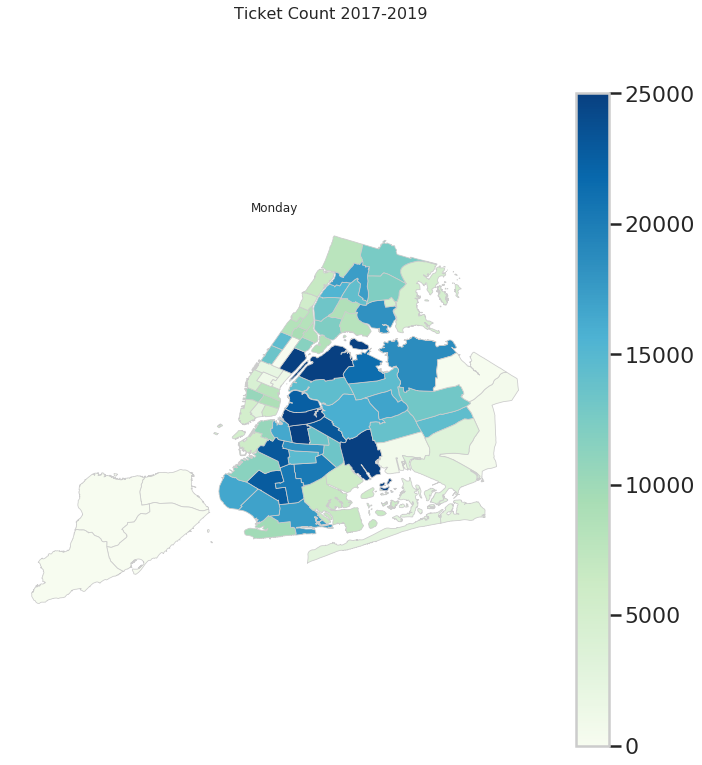

In [29]:
Monday = map_gdf.plot(column='weekday_0', cmap='GnBu', figsize=(12,12), linewidth=0.8, edgecolor='0.8', 
                       legend=True, norm=plt.Normalize(vmin=vmin, vmax=vmax))

Monday.axis('off')

plt.suptitle('Ticket Count 2017-2019', fontsize=16)
plt.title('Monday', fontsize=12)

### Tuesday

Text(0.5, 1, 'Tuesday')

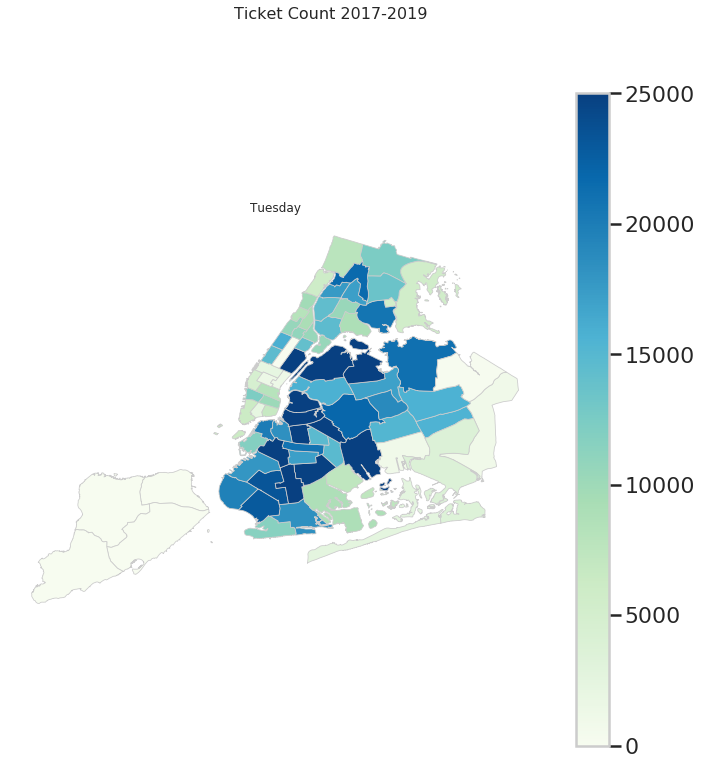

In [30]:
Tuesday = map_gdf.plot(column='weekday_1', cmap='GnBu', figsize=(12,12), linewidth=0.8, edgecolor='0.8', 
                       legend=True, norm=plt.Normalize(vmin=vmin, vmax=vmax))

Tuesday.axis('off')

plt.suptitle('Ticket Count 2017-2019', fontsize=16)
plt.title('Tuesday', fontsize=12)

### Wednesday

Text(0.5, 1, 'Wednesday')

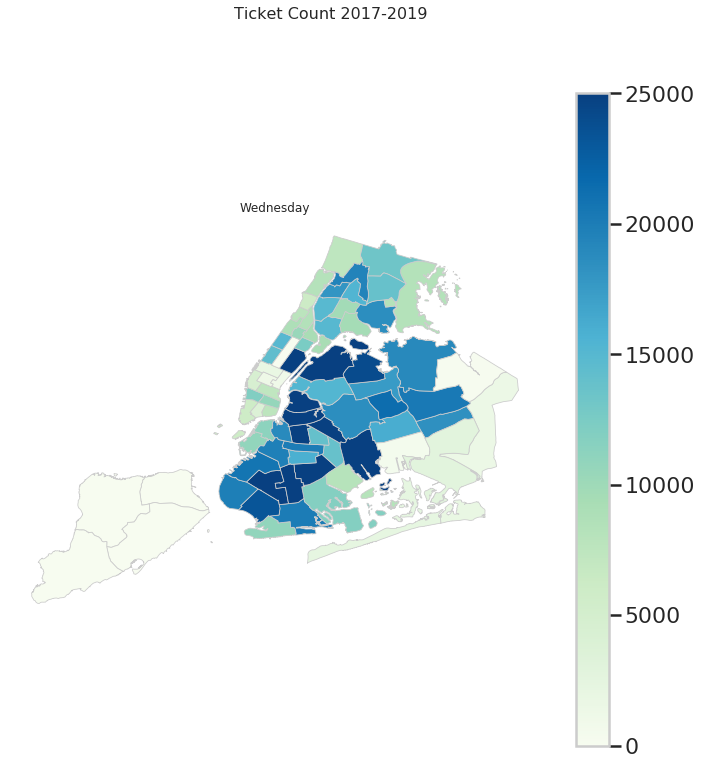

In [31]:
Wednesday = map_gdf.plot(column='weekday_3', cmap='GnBu', figsize=(12,12), linewidth=0.8, edgecolor='0.8', 
                       legend=True, norm=plt.Normalize(vmin=vmin, vmax=vmax))

Wednesday.axis('off')

plt.suptitle('Ticket Count 2017-2019', fontsize=16)
plt.title('Wednesday', fontsize=12)

### Thursday

Text(0.5, 1, 'Thursday')

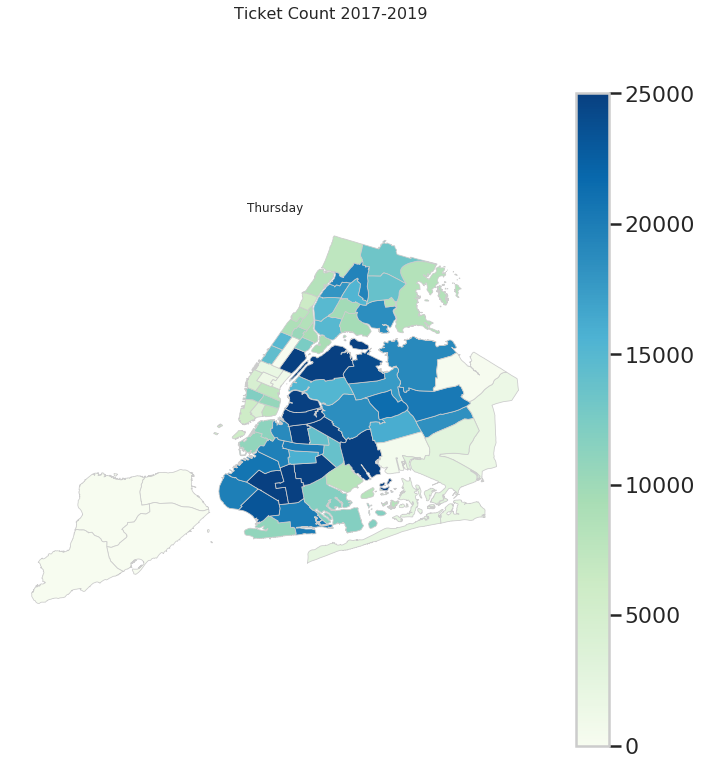

In [32]:
Thursday = map_gdf.plot(column='weekday_3', cmap='GnBu', figsize=(12,12), linewidth=0.8, edgecolor='0.8', 
                       legend=True, norm=plt.Normalize(vmin=vmin, vmax=vmax))

Thursday.axis('off')

plt.suptitle('Ticket Count 2017-2019', fontsize=16)
plt.title('Thursday', fontsize=12)

### Friday

Text(0.5, 1, 'Friday')

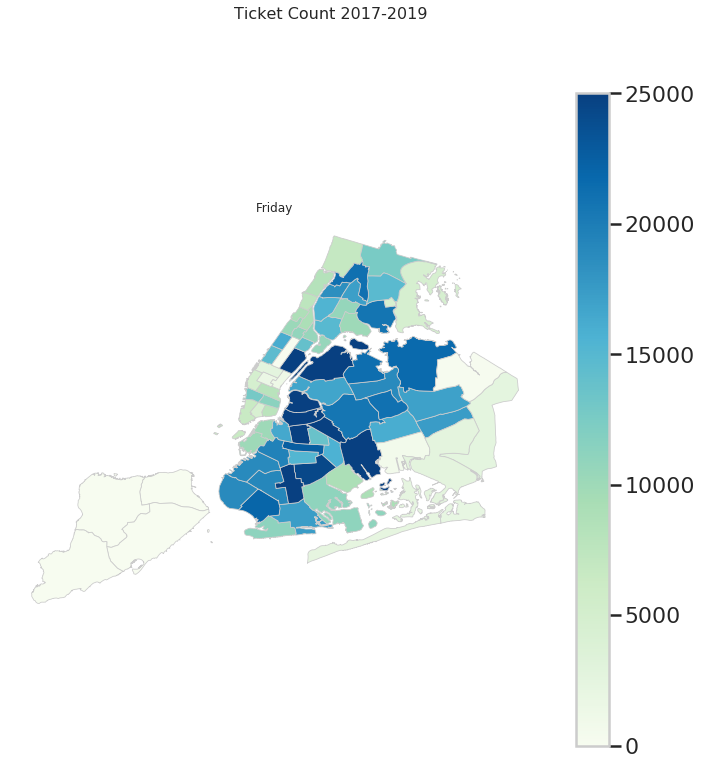

In [33]:
Friday = map_gdf.plot(column='weekday_4', cmap='GnBu', figsize=(12,12), linewidth=0.8, edgecolor='0.8', 
                       legend=True, norm=plt.Normalize(vmin=vmin, vmax=vmax))

Friday.axis('off')

plt.suptitle('Ticket Count 2017-2019', fontsize=16)
plt.title('Friday', fontsize=12)

In [34]:
# fig, ax = plt.subplots(figsize=(12,10), subplot_kw=dict(aspect='equal'))    
# plt.title('Amount Due by Precinct, 2016-2019')
# ax.set_axis_off()
# plt.legend(loc='center left', bbox_to_anchor=(1.1, .5), fontsize='xx-small', frameon=False)
# map_gdf.plot(column='Amount_Due', edgecolor='black',\
#                 scheme='Quantiles', \
#                 k=5, cmap='GnBu', legend=True, ax=ax)

# Timeseries EDA

In [35]:
# Stats
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace import sarimax
from statsmodels.graphics.tsaplots import plot_acf,  plot_pacf
from statsmodels.tools.eval_measures import rmse

#Scipy
from scipy.stats.distributions import chi2
from scipy.stats import norm
from scipy import stats

# Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.utils import resample

In [36]:
timeseries_df = prec_df.copy()

In [37]:
timeseries_df.head()

,Unnamed: 0,Plate,time_issued,Fine_Amount,Amount_Due,Payment_Amount,precinct,State,Bronx,Brooklyn,Manhattan,Queens,Staten_Island,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,9668,KYM0585,2019-12-31 10:00:00,45.0,75.0,75.0,63.0,0,0,1,0,0,0,0,1,0,0,0,0,0
1,9669,3247071,2019-12-31 10:00:00,45.0,55.0,55.0,63.0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,9670,2FWQ91,2019-12-31 10:00:00,45.0,55.0,55.0,63.0,0,0,1,0,0,0,0,1,0,0,0,0,0
3,9671,JDP9488,2019-12-31 10:00:00,45.0,75.0,75.0,63.0,1,0,1,0,0,0,0,1,0,0,0,0,0
4,9672,5TM825,2019-12-31 10:00:00,45.0,75.0,75.0,63.0,0,0,1,0,0,0,0,1,0,0,0,0,0


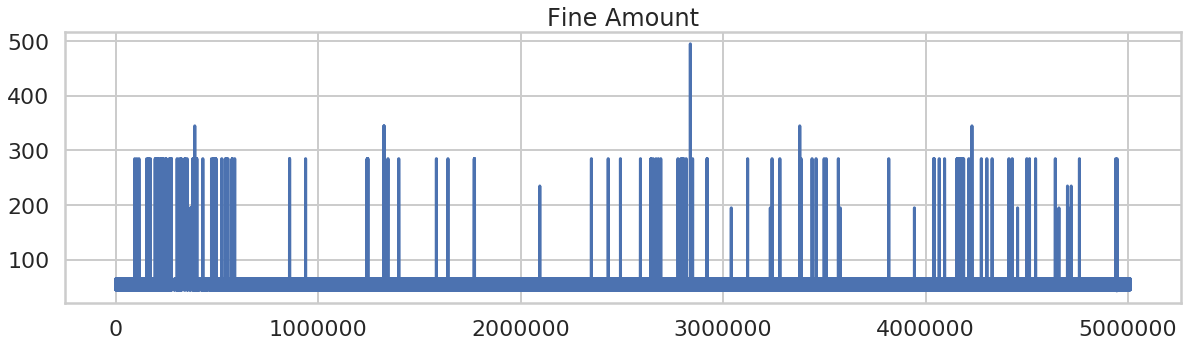

In [38]:
timeseries_df.Fine_Amount.plot(figsize = (20,5))
plt.title("Fine Amount", size= 24)
plt.show()

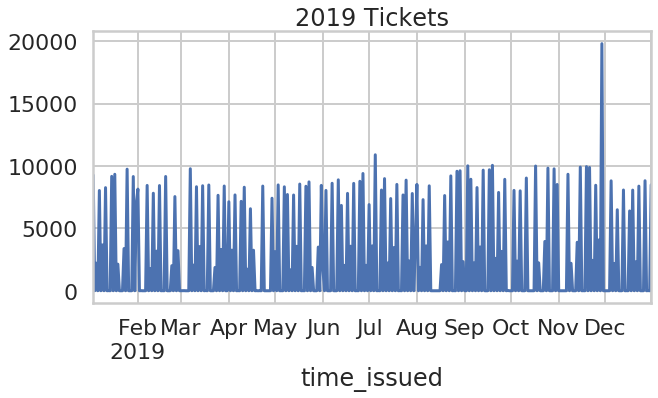

In [39]:
timeseries_df[(timeseries_df['time_issued'].dt.year == 2019) & (timeseries_df['time_issued'].dt.day)]\
.groupby(['time_issued'])['Fine_Amount'].count().resample('d').sum().plot(kind='line',figsize = (10,5))
plt.title("2019 Tickets", size= 24)
plt.show()

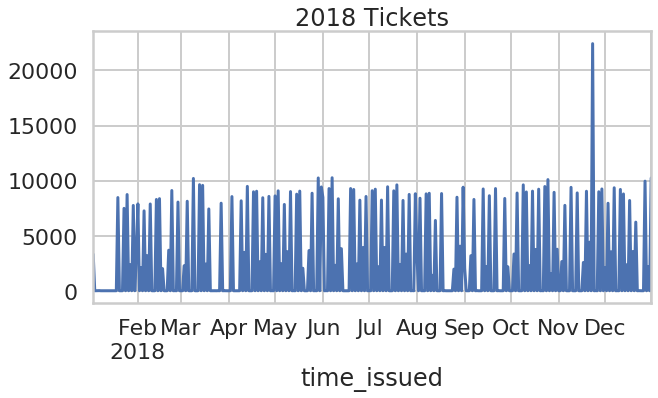

In [40]:
timeseries_df[(timeseries_df['time_issued'].dt.year == 2018) & (timeseries_df['time_issued'].dt.day)]\
.groupby(['time_issued'])['Fine_Amount'].count().resample('d').sum().plot(figsize = (10,5))
plt.title("2018 Tickets", size= 24)
plt.show()

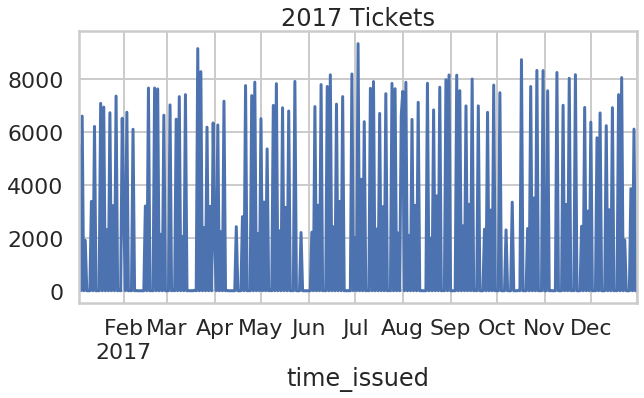

In [41]:
timeseries_df[(timeseries_df['time_issued'].dt.year == 2017) & (timeseries_df['time_issued'].dt.day)]\
.groupby(['time_issued'])['Fine_Amount'].count().resample('d').sum().plot(figsize = (10,5))
plt.title("2017 Tickets", size= 24)
plt.show()

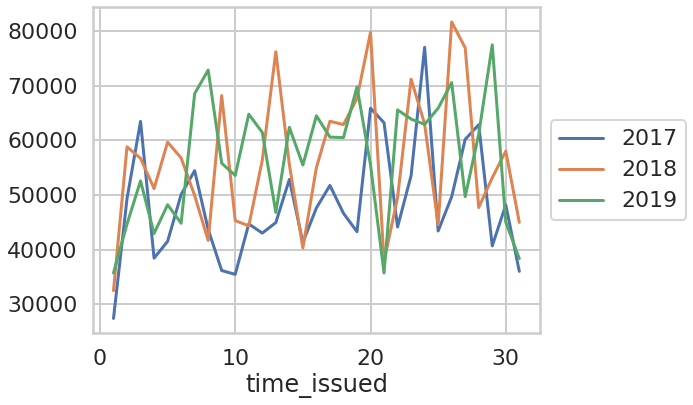

In [42]:
(timeseries_df.groupby([timeseries_df['time_issued'].dt.day,\
                       timeseries_df['time_issued'].dt.year])\
 ['Fine_Amount'].count()).unstack().plot(kind='line')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

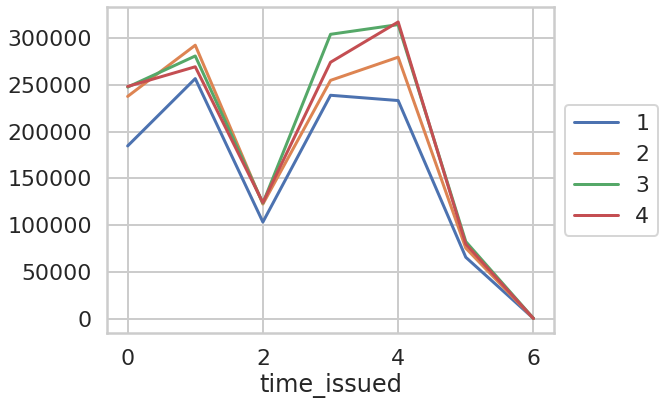

In [43]:
(timeseries_df.groupby([timeseries_df['time_issued'].dt.weekday,\
                       timeseries_df['time_issued'].dt.quarter])\
 ['Fine_Amount'].count()).unstack().plot(kind='line')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Drop Days

### Black Friday
Need to remove this anomoly to smooth the data

In [44]:
timeseries_df = timeseries_df.set_index(timeseries_df['time_issued'])

In [45]:
#Identify Black Friday
BF17 = timeseries_df.loc['2017-11-24']
BF18 = timeseries_df.loc['2018-11-23']
BF19 = timeseries_df.loc['2019-11-29']

In [46]:
def form_t(x):
        return "${:.0f}k".format(x/1000)

In [47]:
BF17_total = BF17.Fine_Amount.sum(axis=0)
BF18_total = BF18.Fine_Amount.sum(axis=0)
BF19_total = BF19.Fine_Amount.sum(axis=0)

print("Summary")

print("Black Friday 2017 Total Fines: ",form_t(BF17_total))
print("Black Friday 2018 Total Fines: ",form_t(BF18_total))
print("Black Friday 2019 Total Fines: ",form_t(BF19_total))

Summary
Black Friday 2017 Total Fines:  $991k
Black Friday 2018 Total Fines:  $1048k
Black Friday 2019 Total Fines:  $931k


Drop it

In [48]:
time_df = timeseries_df.copy()

In [49]:
time_df.shape

(5010716, 20)

In [50]:
time_df.loc['2017-11-24']=np.nan
time_df.loc['2018-11-23']=np.nan
time_df.loc['2019-11-29']=np.nan
time_df.dropna(inplace = True)

In [51]:
time_df.shape

(4947366, 20)

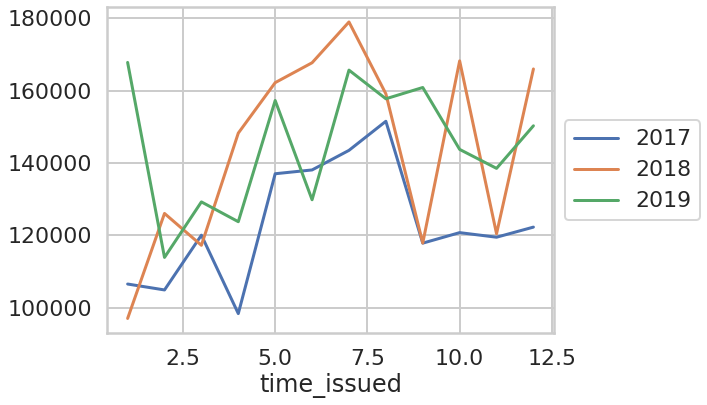

In [52]:
(time_df.groupby([time_df['time_issued'].dt.month,\
                       time_df['time_issued'].dt.year])\
 ['Fine_Amount'].count()).unstack().plot(kind='line')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

Text(0, 0.5, 'Total Fine Amount in USD')

findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.


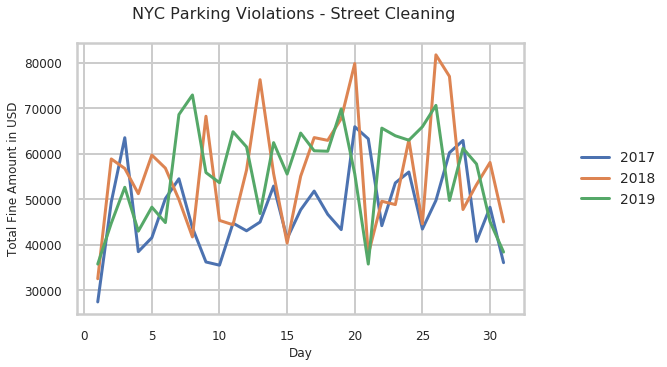

In [53]:
(time_df.groupby([time_df['time_issued'].dt.day,\
                       time_df['time_issued'].dt.year])\
 ['Fine_Amount'].count()).unstack().plot(kind='line', figsize=(8,5))

plt.legend(loc='center left', bbox_to_anchor=(1.1, .5), fontsize='xx-small', frameon=False)
plt.suptitle('NYC Parking Violations - Street Cleaning', fontsize=16)
plt.tick_params(labelsize = 12)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Total Fine Amount in USD', fontsize=12)

Text(0, 0.5, 'Total Fine Amount in USD')

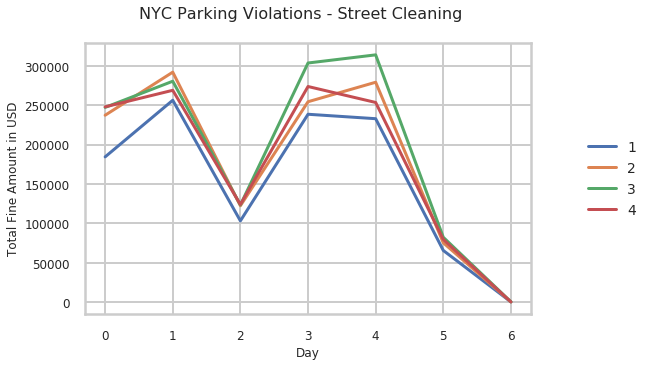

In [54]:
(time_df.groupby([time_df['time_issued'].dt.weekday,\
                       time_df['time_issued'].dt.quarter])\
 ['Fine_Amount'].count()).unstack().plot(kind='line', figsize=(8,5))

plt.legend(loc='center left', bbox_to_anchor=(1.1, .5), fontsize='xx-small', frameon=False)
plt.suptitle('NYC Parking Violations - Street Cleaning', fontsize=16)
plt.tick_params(labelsize = 12)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Total Fine Amount in USD', fontsize=12)

Text(0, 0.5, 'Total Fine Amount in USD')

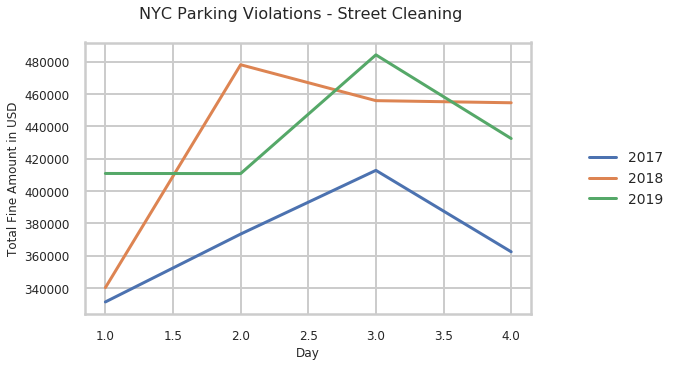

In [55]:
(time_df.groupby([time_df['time_issued'].dt.quarter,\
                       time_df['time_issued'].dt.year])\
 ['Fine_Amount'].count()).unstack().plot(kind='line', figsize=(8,5))

plt.legend(loc='center left', bbox_to_anchor=(1.1, .5), fontsize='xx-small', frameon=False)
plt.suptitle('NYC Parking Violations - Street Cleaning', fontsize=16)
plt.tick_params(labelsize = 12)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Total Fine Amount in USD', fontsize=12)

# Weather Data

Summary

In [56]:
time_df.reset_index(drop=True, inplace=True)

bysum=time_df.groupby(["time_issued"]).agg({'Fine_Amount':'sum','Amount_Due':'sum', 'Payment_Amount':'sum'})
bysum.head()

def form_m(x):
        return "${:.1f}m".format(x/1000000)
    
    
fine_total = bysum.Fine_Amount.sum(axis=0)
due_total= bysum.Amount_Due.sum(axis=0)
payment_total = bysum.Payment_Amount.sum(axis=0)

print("Summary")
print("Total Fines: ",form_m(fine_total))
print("Total Amount Due: ",form_m(due_total))
print("Total Payment Amount: ",form_m(payment_total))

Summary
Total Fines:  $232.9m
Total Amount Due:  $48.1m
Total Payment Amount:  $48.1m


Date

In [57]:
# precinct_dummies = pd.get_dummies(time_df['precinct'], prefix='precinct')
# time_df = pd.concat([time_df, precinct_dummies], axis=1)
# time_df.head()

In [58]:
bydate=time_df.groupby(["time_issued"]).agg({'Fine_Amount':'count',\
                                            'weekday_0':'sum','weekday_1':'sum','weekday_2':'sum',\
                                           'weekday_3':'sum','weekday_4':'sum','weekday_5':'sum','weekday_6':'sum',\
                                            'Manhattan':'sum','Brooklyn':'sum','Bronx':'sum','Queens':'sum'})
bydate=bydate.asfreq('B')
bydate.head()

,Fine_Amount,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,Manhattan,Brooklyn,Bronx,Queens
time_issued,,,,,,,,,,,,
2017-01-02,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2017-01-03,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0
2017-01-04,28.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0,11.0,10.0,2.0,5.0
2017-01-05,52.0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,10.0,22.0,15.0,5.0
2017-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
weather_raw_data = pd.read_csv('CLEAN_weather_200416.csv')
weather = weather_raw_data.copy()

FileNotFoundError: [Errno 2] File CLEAN_weather_200416.csv does not exist: 'CLEAN_weather_200416.csv'

In [ ]:
weather['time_issued']=pd.to_datetime(weather['time_issued'], yearfirst=True, errors='coerce')

In [ ]:
weather=weather.groupby(["time_issued"])\
.agg({'Precipitation':'mean', \
      'Temperature':'mean', 'Wind':'mean'})

weather= weather.asfreq('B')
weather.head()

In [ ]:
weather_fine = pd.merge(bydate,weather,how='left',on='time_issued')

print('weather:',weather.shape)
print('   fine:',bydate.shape)
print(' weather_fine:',weather_fine.shape)

In [ ]:
weather_fine.isna().sum()

In [ ]:
weather_fine=weather_fine.fillna(method='pad')

## Correlation

In [ ]:
# sns.heatmap

corrmat = weather_fine[['Fine_Amount',\
              'Precipitation', 'Temperature', 'Wind'\
             ]].corr()
fig,ax= plt.subplots()
fig.set_size_inches(10,10)
sns.heatmap(corrmat,square=True,annot=True)

In [ ]:
X_weather_fine = weather_fine.drop(['Fine_Amount'],axis=1)
y_weather_fine = weather_fine['Fine_Amount']

sns.set(style="whitegrid", palette=("deep"),font='calibri')
sns.set_context("poster")

X_weather_fine.corrwith(weather_fine['Fine_Amount']).plot.bar(figsize = (20, 10), title ="Correlation with Fine", fontsize = 10,
rot = 90, grid = True,)

sns.palplot(sns.color_palette())

In [ ]:
weather_fine.Fine_Amount.plot()
weather_fine.Temperature.plot()

# Models

## Train Test Split

In [ ]:
weather_fine.Fine_Amount.plot(figsize = (20,5))
plt.title("Fine Amount", size= 24)
plt.show()

In [ ]:
weather_fine.head(5)

In [ ]:
size = int(len(weather_fine)*0.8)

In [ ]:
df_train, df_test = weather_fine.iloc[:size], weather_fine.iloc[size:]

In [ ]:
zero_dict = {np.nan: 0}
weather_fine.replace(zero_dict, inplace = True)
weather_fine.dropna(inplace = True)

weather_fine.info()

In [ ]:
weather_fine.columns

### Dickey-Fuller Test

In [ ]:
def test_stationarity(timeseries, window):
    
#Determine rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(10, 5),)
    orig = plt.plot(timeseries.iloc[window:], color='lightgrey',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc=1, fontsize='x-small', )
    plt.xticks(rotation=90)
    plt.legend(loc='center left', bbox_to_anchor=(1.1,.5), fontsize='xx-small', frameon=False)
    plt.suptitle('Rolling Mean & Standard Deviation', fontsize=16)
    plt.tick_params(labelsize = 12)
    plt.xlabel('Day', fontsize=12)
    plt.ylabel('Total Fine Amount in USD', fontsize=12)
    plt.show()

# Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

letslook = weather_fine.groupby('time_issued')['Fine_Amount'].count()
test_stationarity(letslook, 24)

In [ ]:
sts.adfuller(df_train.Fine_Amount) # dickey-fuller test to check for staionarity 

In [ ]:
log_series = df_train.Fine_Amount.apply(lambda x: np.log(x))  
sts.adfuller(log_series)

In [ ]:
decomposition = seasonal_decompose(df_train.Fine_Amount, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [ ]:
decomposition = seasonal_decompose(log_series, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

### AR Model

In [ ]:
model_ar=ARIMA(df_train["Fine_Amount"],(5,1,0))
model_ar_fit=model_ar.fit()

In [ ]:
# prediction_ar= model_ar_fit.forecast(len(df_test))[0]
# y_pred["AR Model Prediction"]=list(np.exp(prediction_ar))
# y_pred

In [ ]:
# plt.figure(figsize=(10,5))
# plt.plot(df_train.index,df_train["Fine_Amount"],label="Train Set")
# plt.plot(df_test.index,df_test["Fine_Amount"],label="Test Set")
# plt.plot(y_pred["AR Model Prediction"],label="AR Model Prediction set")
# plt.legend()
# plt.xlabel("Date")
# plt.ylabel('Confirmed Cases')
# plt.title('AR Model: Confirmed')
# plt.xticks(rotation=90)

In [ ]:
# AR_model_new_prediction_death=[]
# for i in range(1,18):
#     AR_model_new_prediction_d.append(np.exp(results_ar_death.forecast(len(df_test)+i)[0][-1]))
# model_predictions["AR Model Prediction_death"]=AR_model_new_prediction_death

In [ ]:
# model_predictions=pd.DataFrame(zip(new_date),columns=["Dates"])

In [ ]:
# new_date=[]
# AR_model_new_prediction=[]
# for i in range(1,18):
#     new_date.append(bydate.index[-1]+timedelta(days=i))
#     AR_model_new_prediction.append(np.exp(model_ar_fit.forecast(len(df_test)+i)[0][-1]))

In [ ]:
# model_predictions["AR Model Prediction"]=AR_model_new_prediction

In [ ]:
# model_predictions

### MA Model

In [ ]:
# model_ma=ARIMA(df_train["Fine_Amount"],(0,1,5))
# model_ma_fit=model_ma.fit()

In [ ]:
# prediction_ma= model_ma_fit.forecast(len(df_test))[0]
# y_pred["MA Model Prediction"]=list(np.exp(prediction_ma))

In [ ]:
# plt.figure(figsize=(10,5))
# plt.plot(df_train.index,df_train.Fine_Amount,label="Train Set")
# plt.plot(df_test.index,df_test.Fine_Amount,label="Test Set")
# plt.plot(y_pred["MA Model Prediction"],label="MA Prediction Set")
# plt.legend()
# plt.xlabel("Date")
# plt.ylabel('Confirmed Cases')
# plt.xticks(rotation=90)

In [ ]:
# MA_model_new_prediction=[]
# for i in range(1,18):
#     MA_model_new_prediction.append(np.exp(model_ma_fit.forecast(len(df_test)+i)[0][-1]))
# model_predictions["MA Model Prediction"]=MA_model_new_prediction

### SARIMA

In [ ]:
from pmdarima import auto_arima  

In [ ]:
auto_arima(weather_fine['Fine_Amount'],seasonal=True,m=12).summary()

# SARIMAX(2, 0, 3)x(1, 0, [], 12)

In [ ]:
model = SARIMAX(df_train['Fine_Amount'],order=(2,0,3),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

In [ ]:
start=len(df_train)
end=len(df_train)+len(df_test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,0)(2,0,0,12) Predictions')

In [ ]:
title='NYC Parking Tickets'
ylabel='Fine Amount'
xlabel=''

ax.legend(loc='center left', bbox_to_anchor=(1.1, .5), fontsize='xx-small', frameon=False)

ax = df_test['Fine_Amount'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [ ]:
error1 = mean_squared_error(df_test['Fine_Amount'], predictions)
error2 = rmse(df_test['Fine_Amount'], predictions)
print(f'SARIMA(0,1,0)(2,0,0,12) MSE Error: {error1:11.10}')
print(f'SARIMA(0,1,0)(2,0,0,12) RMSE Error: {error2:11.10}')

In [ ]:
model = SARIMAX(df_test['Fine_Amount'],order=(3,1,3),seasonal_order=(1,0,1,12))
results = model.fit()
fcast = results.predict(len(df_test),len(df_test)+11,typ='levels').rename('SARIMA(3,1,3)(1,0,1,12) Forecast')
# (3,1,3),seasonal_order=(1,0,1,12))

In [ ]:
title='Fine Amount'


ax = df_test['Fine_Amount'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
plt.legend(loc='center left', bbox_to_anchor=(1.1, .5), fontsize='xx-small', frameon=False)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

plt.tick_params(labelsize = 12)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Total Fine Amount in USD', fontsize=12)

### XGBoost

In [ ]:
#XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
xgb_df = weather_fine.copy()

In [ ]:
xgb_df.columns

In [ ]:
X = xgb_df.drop(['Fine_Amount'],axis=1)
y = xgb_df['Fine_Amount']
feature_cols = X.columns

In [ ]:
X.corrwith(xgb_df['Fine_Amount']).plot.bar(
        figsize = (20, 10), title = "Correlation with Fine", fontsize = 20,
        rot = 90, grid = True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)

In [ ]:
training = pd.concat([X_train,y_train], axis =1)

In [ ]:
# # UPSAMPLING

# nprecinct_114 = training[training['precinct_114.0']==0]
# precinct_114 = training[training['precinct_114.0']>=1]

In [ ]:
# upsampled = resample(precinct_114,
#                           replace=True, # sample with replacement
#                           n_samples=len(nprecinct_114), # match number in majority class
#                           random_state=23) # reproducible results

# upsampled = pd.concat([nprecinct_114, upsampled])
# upsampled['precinct.114'].value_counts()

In [ ]:
# X_train = upsampled.drop('nprecinct_114', axis = 1)
# y_train = upsampled['nprecinct_114']
# feature_cols = X_train.columns
# Line

# # upsampled

In [ ]:
X_train.columns

In [ ]:
xgb.XGBClassifier()
xg_clf = xgb.XGBClassifier(objective ='reg:logistic', 
                           colsample_bytree = 0.3, 
                           subsample = 0.5,
                           learning_rate = 0.3,
                           max_depth = 3, 
                           alpha = 1, 
                           n_estimators = 1000)
xg_clf.fit(X_train,y_train)
preds = xg_clf.predict(X_test)

test_f1 = f1_score(y_test, preds,average='weighted')
test_acc = accuracy_score(y_test, preds)

print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))

DO NOT DELETE!! Uncomment for future use

In [ ]:
# precinct_dummies = pd.get_dummies(time_df['precinct'], prefix='precinct')
# time_df = pd.concat([prec_df, precinct_dummies], axis=1)
# #Line
# size = int(len(time_df)*0.8)
# time_df_train, time_df_test = time_df.iloc[:size], time_df.iloc[size:]
# y_pred = time_df_test.copy()
# #Line

# log_series=np.log(df_train["Fine_Amount"])
# #Line

# xgb_df = time_df.copy()
# #Line

# xgb_df.columns
# #Line

# xgb_df.drop(['Unnamed: 0', 'Plate', 'time_issued', 'Amount_Due',
#        'Payment_Amount', 'Bronx', 'Brooklyn', 'Manhattan',
#        'Queens', 'Staten_Island', 'weekday_2'\
#     ], axis=1, inplace=True)
# #Line

# X = xgb_df.drop(['state_0'],axis=1)
# y = xgb_df['state_0']

# X.corrwith(xgb_df3['state_0']).plot.bar(
#         figsize = (20, 10), title = "Correlation with Precinct93", fontsize = 20,
#         rot = 90, grid = True)
# #Line

# X = xgb_df.drop('precinct', axis = 1)
# y = xgb_df['precinct']
# feature_cols = X.columns
# #Line

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)
# #Line

# training = pd.concat([X_train,y_train], axis =1)
# #Line

# # UPSAMPLING

# # nweekday_2 = training[training['weekday_2']==0]
# # weekday_2 = training[training['weekday_2']==1]
# #Line
# # from sklearn.dummy import DummyClassifier
# # from sklearn.metrics import accuracy_score, f1_score
# # from sklearn.utils import resample

# # upsampled = resample(nweekday_2,
# #                           replace=True, # sample with replacement
# #                           n_samples=len(nweekday_2), # match number in majority class
# #                           random_state=23) # reproducible results

# # upsampled = pd.concat([nweekday_2, upsampled])
# # upsampled['weekday_2'].value_counts()
# #Line

# # X_train = upsampled.drop('nweekday_2', axis = 1)
# # y_train = upsampled['nweekday_2']
# # feature_cols = X_train.columns
# #Line

# # upsampled
# #Line

# X_train.columns
# #Line

# from xgboost import XGBClassifier
# from sklearn.metrics import f1_score
# import xgboost as xgb
# from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score
# #Line

# # xgb.XGBClassifier()
# # xg_clf = xgb.XGBClassifier(objective ='binary:logistic', 
# #                            colsample_bytree = 0.3, 
# #                            subsample = 0.5,
# #                            learning_rate = 0.1,
# #                            max_depth = 4, 
# #                            alpha = 1, 
# #                            n_estimators = 1000)
# # xg_clf.fit(X_train,y_train)
# # preds = xg_clf.predict(X_test)

# # test_f1 = f1_score(y_test, preds)
# # test_acc = accuracy_score(y_test, preds)

# # print("Accuracy: %f" % (test_acc))
# # print("F1: %f" % (test_f1))
# #Line